## 1. Import needed libraries and Set Device

In [1]:
# --- General Libraries ---
import os
import random
import time
import warnings

# --- Data Handling ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score

# --- Image Handling and Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

# --- PyTorch and Deep Learning ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm  # For EfficientNet and other pretrained models

# --- Utilities ---
from tqdm import tqdm  # For training progress visualization
import torch.profiler  # Optional: For GPU usage profiling

# --- Warning Suppression ---
warnings.filterwarnings('ignore')


c:\Users\burakdogan\Desktop\lc2500-Not_Working\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

Using cuda device
True
1
0
NVIDIA GeForce RTX 4060 Ti


### 2. Data Loading and Preprocessing

In this section, we use `torchvision.datasets.ImageFolder` to load lung image data (lung_aca, lung_n, lung_scc). 
We also apply necessary transformations (resizing, normalization), split the dataset into training and validation sets, 
and prepare DataLoaders with GPU support.


In [3]:
# Function to load the dataset from the specified directory
def loading_the_data(data_dir):

    # Initialize empty lists to store file paths and corresponding labels
    filepaths = []  # List to hold paths of the images
    labels = []     # List to hold the labels (folder names)

    # Get the list of subdirectories (each represents a class label)
    folds = os.listdir(data_dir)

    # Loop through each subdirectory
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)  # Get the path of the subdirectory
        filelist = os.listdir(foldpath)  # Get the list of files in the subdirectory

        # Loop through each file in the subdirectory
        for file in filelist:
            fpath = os.path.join(foldpath, file)  # Get the full file path
            
            filepaths.append(fpath)  # Add the file path to the list
            labels.append(fold)      # Add the label (folder name) to the list

    # Convert the lists into pandas Series
    Fseries = pd.Series(filepaths, name='filepaths')  # Series for file paths
    Lseries = pd.Series(labels, name='labels')        # Series for labels

    # Concatenate the two Series into a single DataFrame
    df = pd.concat([Fseries, Lseries], axis=1)
    
    return df  # Return the DataFrame containing the file paths and labels

In [ ]:
# Define the path to the dataset directory
data_dir = './lung_colon_image_set/lung_image_sets'  # Update the path based on your current directory structure

# Load the data using the function
df = loading_the_data(data_dir)

# Display the first few rows of the DataFrame to verify the data
df.head()

,filepaths,labels
0,./lung_colon_image_set/lung_image_sets\lung_ac...,lung_aca
1,./lung_colon_image_set/lung_image_sets\lung_ac...,lung_aca
2,./lung_colon_image_set/lung_image_sets\lung_ac...,lung_aca
3,./lung_colon_image_set/lung_image_sets\lung_ac...,lung_aca
4,./lung_colon_image_set/lung_image_sets\lung_ac...,lung_aca


In [5]:
X = df['filepaths']  # or your feature columns
y = df['labels']     # or your target column

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (15000,)
y shape: (15000,)


In [6]:
print("Full DataFrame shape:", df.shape)

Full DataFrame shape: (15000, 2)


## 3. Data Visualization

##### Random Images from Three Classes

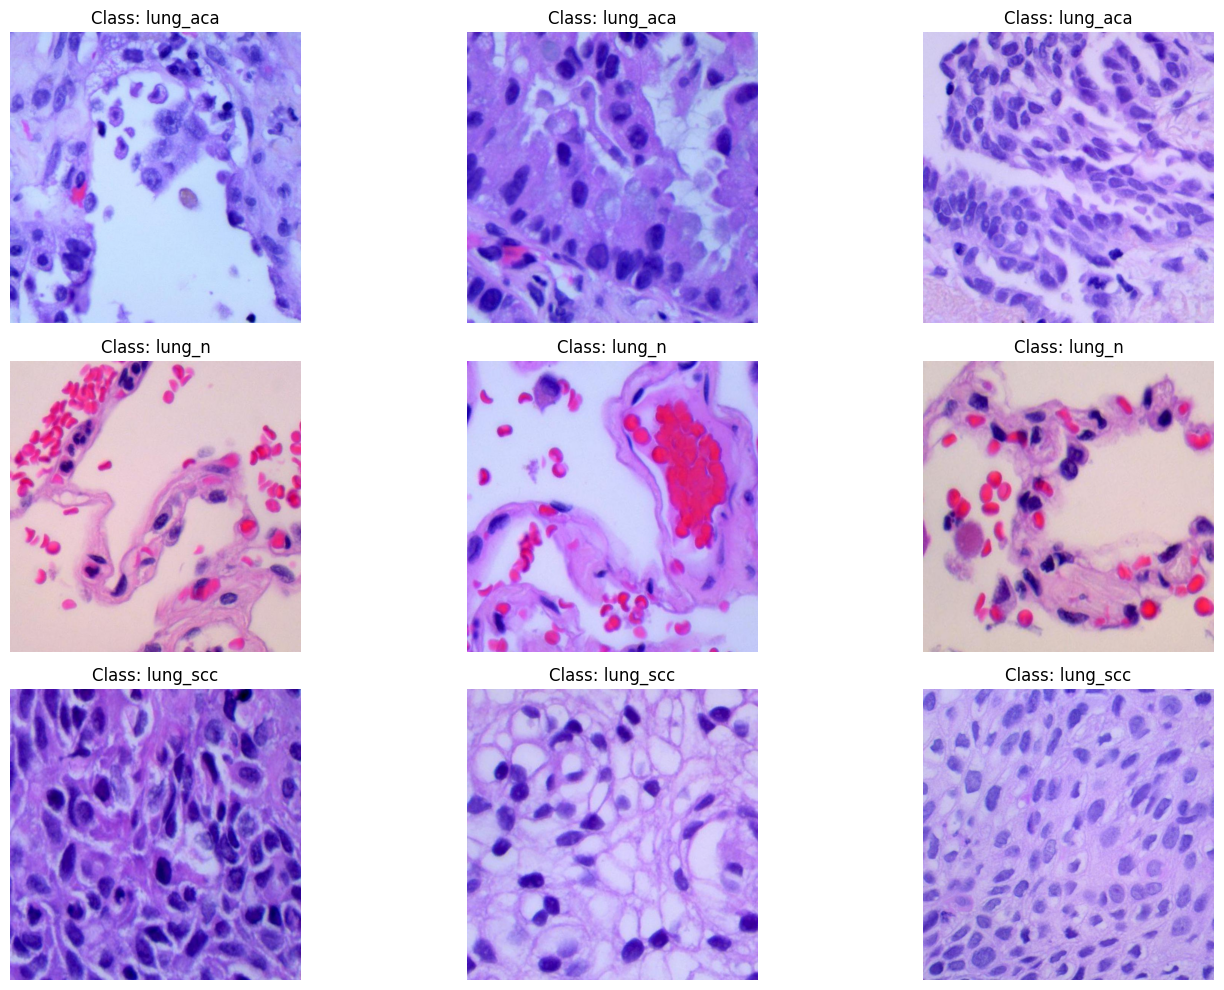

In [7]:
# Get unique class names
class_names = sorted(df['labels'].unique())
num_classes = len(class_names)

selected_classes = class_names[:3] 
num_images_per_class = 3  

plt.figure(figsize=(15, 10))

for idx, class_name in enumerate(selected_classes):
    class_df = df[df['labels'] == class_name]
    
    random_samples = class_df.sample(num_images_per_class)
    
    for i, (_, row) in enumerate(random_samples.iterrows()):
        image_path = row['filepaths']
        
        image = plt.imread(image_path)
        
        plt.subplot(3, len(selected_classes), idx * num_images_per_class + i + 1)
        plt.imshow(image)
        plt.title(f"Class: {class_name}")
        plt.axis("off")

plt.tight_layout()
plt.show()

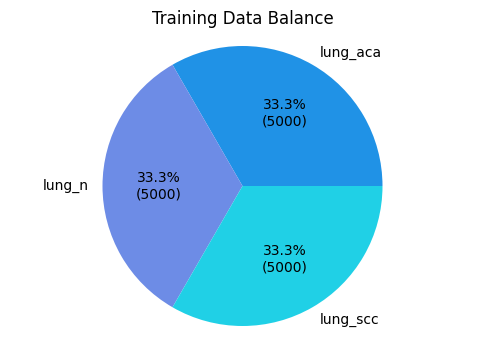

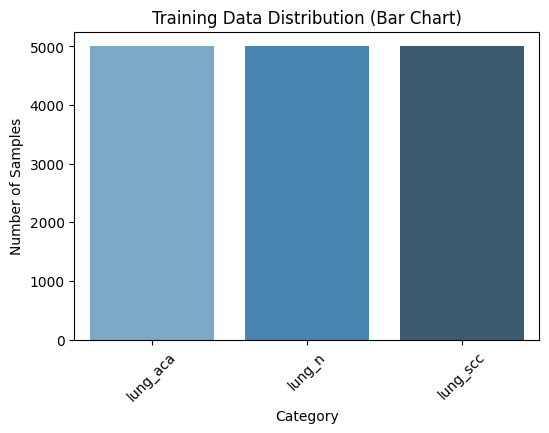

Statistical Summary of the Data Balance:
count       3.0
mean     5000.0
std         0.0
min      5000.0
25%      5000.0
50%      5000.0
75%      5000.0
max      5000.0
Name: count, dtype: float64


In [8]:
data_balance = df.labels.value_counts()

# Data Balance Pie Chart with enhanced details
def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)

# Pie Chart
plt.figure(figsize=(6, 4))
plt.pie(data_balance, labels=data_balance.index, autopct=custom_autopct, colors=["#2092E6", "#6D8CE6", "#20D0E6"])
plt.title("Training Data Balance")
plt.axis("equal")
plt.show()

# Bar Chart for Category Distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=data_balance.index, y=data_balance.values, palette="Blues_d")
plt.title("Training Data Distribution (Bar Chart)")
plt.xlabel("Category")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()

# Additional Statistical Info (Number of categories, mean, median, etc.)
print("Statistical Summary of the Data Balance:")
print(data_balance.describe())

In [9]:
data_balance.index

Index(['lung_aca', 'lung_n', 'lung_scc'], dtype='object', name='labels')

## 4. Data Preprocessing and Splitting

##### Dataset Preparation
We will use the custom LungDataset class to wrap our DataFrame objects and prepare them for PyTorch models using DataLoader.

In [10]:
# Custom PyTorch Dataset class
class LungDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)  # reset index to ensure continuous indices
        self.transform = transform  # image transformations (e.g. resizing, normalization)
        self.label2idx = {label: idx for idx, label in enumerate(sorted(self.df['labels'].unique()))}
        
        print(f"Dataset loaded with {len(self.df)} samples.")

    def __len__(self):
        return len(self.df)  # total number of samples

    def __getitem__(self, idx):
        image_path = self.df.loc[idx, 'filepaths']  # get image file path
        label = self.label2idx[self.df.loc[idx, 'labels']]  # convert label to index
        
        image = Image.open(image_path)  # open image
        if self.transform:
            image = self.transform(image)  # apply transformations (e.g. ToTensor)

        return image, label  # return transformed image and numeric label


##### Image Transforms
We use torchvision.transforms to resize, normalize, and convert images into PyTorch tensors.

In [11]:
IMG_SIZE = 224  # Define the image size for resizing
BATCH_SIZE = 128  # Define the batch size for DataLoader
MODEL_NAME = 'efficientnet_b3'  # Define the model name for transfer learning

In [12]:
def get_transforms():
    return transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
    ])

In [13]:
# 1. **Dataset Preparation**
print("Splitting and filtering dataset...")
train_df, test_df = train_test_split(df, train_size=0.8, random_state=42, shuffle=True)

# Filter dataset for selected classes (lung_aca, lung_n, lung_scc)
#print("Filtering dataset for selected classes...")
#train_df = train_df[train_df['labels'].isin(class_names)]
#test_df = test_df[test_df['labels'].isin(class_names)]

# Create dataset objects
transform = get_transforms()
train_dataset = LungDataset(train_df, transform)
test_dataset = LungDataset(test_df, transform)

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

Splitting and filtering dataset...
Dataset loaded with 12000 samples.
Dataset loaded with 3000 samples.


In [14]:
print("Train DataFrame shape after filtering:", train_df.shape)
print("Test DataFrame shape after filtering:", test_df.shape)

# Optionally, inspect class distributions too:
print("Train class distribution:\n", train_df['labels'].value_counts())
print("Test class distribution:\n", test_df['labels'].value_counts())

Train DataFrame shape after filtering: (12000, 2)
Test DataFrame shape after filtering: (3000, 2)
Train class distribution:
 labels
lung_n      4030
lung_scc    4007
lung_aca    3963
Name: count, dtype: int64
Test class distribution:
 labels
lung_aca    1037
lung_scc     993
lung_n       970
Name: count, dtype: int64


In [15]:
# EfficientNet'i yükle
efficientnet = timm.create_model('efficientnet_b3', pretrained=True)
efficientnet = efficientnet.to(device)
efficientnet.eval()  # Eğitim yapılmayacağı için eval moduna al

# Sınıflandırıcı katmanı dahil değil → özellik çıkarımı için
feature_extractor = nn.Sequential(*list(efficientnet.children())[:-1])
feature_extractor = feature_extractor.to(device)


In [16]:
def extract_features(model, dataloader):
    features = []
    labels = []

    with torch.no_grad():
        for inputs, labels_batch in tqdm(dataloader):
            inputs = inputs.to(device)
            outputs = model(inputs)
            outputs = outputs.view(outputs.size(0), -1)  # Flatten
            features.append(outputs.cpu().numpy())
            labels.append(labels_batch.cpu().numpy())

    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels


In [17]:
print("Extracting features from training data...")
X_train, y_train = extract_features(feature_extractor, train_loader)

print("Extracting features from test data...")
X_test, y_test = extract_features(feature_extractor, test_loader)


Extracting features from training data...


100%|██████████| 94/94 [01:17<00:00,  1.22it/s]


Extracting features from test data...


100%|██████████| 24/24 [00:19<00:00,  1.23it/s]


In [18]:
print("Training Random Forest classifier...")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

print("Evaluating on test data...")
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=class_names))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("Confusion Matrix:\n", pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted']))
print("Feature extraction and classification completed successfully.")

Training Random Forest classifier...
Evaluating on test data...
              precision    recall  f1-score   support

    lung_aca       0.98      0.95      0.97      1037
      lung_n       1.00      1.00      1.00       970
    lung_scc       0.95      0.98      0.97       993

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000

Accuracy: 0.9763333333333334
F1 Score: 0.9763432535395565
Confusion Matrix:
 Predicted    0    1    2
Actual                  
0          990    0   47
1            2  968    0
2           22    0  971
Feature extraction and classification completed successfully.
